# Gradient Boosting Machines (GBM)
### Gradient Boosting Machines (GBM) is an ensemble machine learning algorithm that builds a predictive model by iteratively combining weak learners, typically decision trees, to minimize prediction errors. Unlike Random Forest, which trains trees independently, GBM sequentially trains trees, with each tree correcting the residuals of the previous ones, enhancing accuracy through gradient descent optimization. This makes it highly effective for both classification (e.g., predicting wine quality categories) and regression tasks, excelling in datasets with complex patterns. The algorithm assumes that the weak learners can be improved iteratively and benefits from sufficient data to learn from residuals, though it does not require strict distributional assumptions. Its superior performance on structured/tabular data comes at the cost of slower training times and a higher risk of overfitting if not properly tuned (e.g., with learning rate or tree depth).

### Use GBM when seeking high accuracy, with hyperparameter tuning (e.g., learning rate, number of estimators) to balance performance and prevent overfitting, especially for deployment in production systems.

| Aspect | Details |
| :- | :- |
| Use For           | Classification (e.g., wine quality prediction, customer churn analysis)<br>Regression (e.g., energy consumption forecasting, stock price estimation) |
| Key Assumptions   | - Weak learners (e.g., decision trees) can be improved iteratively<br>- Independent observations<br>- Sufficient data to learn from residuals |
| Advantages        | - High accuracy through sequential error correction<br>- Excels with complex, structured data<br>- Flexible with various loss functions |
| Disadvantages     | - Slower training due to sequential learning<br>- Prone to overfitting if not tuned<br>- Requires careful hyperparameter adjustment |
| Avoid When        | - Real-time applications needing low latency<br>- Very small datasets with limited patterns<br>- Need for highly interpretable models |
| Real-World Use Case | Wine quality prediction (e.g., classifying quality based on chemical properties)<br>Customer churn prediction (e.g., identifying at-risk customers from behavior data) |

## Problem Description: 
### Predict the quality of red wine (rated from 0 to 10) based on physicochemical properties like alcohol content, pH, and volatile acidity. 

Using Kaggle dataset https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

## Modified Approach to improve accuracy:
- feature engineering adding new features
- increase n_estimators - more trees allow model to learn more complex patterns if not overfit
- increase max_depth - captures more intricate relationships but can cause overfitting if too deep
- learning rate - reduce to allow more gradual learning and improve generalization
- early stopping to stop training when accuracy plateaus, preventing overfitting

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
project_dir = './05_gradient_boosting'

# load  dataset
data = pd.read_csv(project_dir + '/data/winequality-red.csv')
print("Dataset loaded, shape:", data.shape)

# feature engineering: add total acidity - to increase accuracy
data['total_acidity'] = data['fixed acidity'] + data['volatile acidity'] + data['citric acid']

# select key features and target variable
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 
            'total_acidity']

X = data[features] 
y = data['quality']
print("Features shape:", X.shape, "Target shape:", y.shape)

# scale features to improve model performance.
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)

Dataset loaded, shape: (1599, 12)
Features shape: (1599, 12) Target shape: (1599,)


In [3]:
# split data into training and testing sets.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=40)
print("Train set shape:", X_train.shape, "Validation set shape:", X_val.shape, "Test set shape:", X_test.shape)

Train set shape: (1023, 12) Validation set shape: (256, 12) Test set shape: (320, 12)


In [4]:
# train the Gradient Boosting model
gbm_model = GradientBoostingClassifier(
    n_estimators=500,  # Increased from 100 to 500
    max_depth=5,       # Increased from 3 to 5
    learning_rate=0.01,  # Reduced from 0.1 to 0.05
    random_state=40
)
gbm_model.fit(X_train, y_train)


# early stopping with validation set (manual check)
best_val_accuracy = 0
best_model = None
for i in range(10, 501, 10):  # iterate over n_estimators
    temp_model = GradientBoostingClassifier(n_estimators=i, max_depth=5, learning_rate=0.05, random_state=40)
    temp_model.fit(X_train, y_train)
    val_pred = temp_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = temp_model
    if i > 100 and val_accuracy < best_val_accuracy - 0.01:  # Stop if accuracy drops by 0.01
        break
gbm_model = best_model  # use the best model from early stopping

In [5]:
# predict and evaluate the model
y_pred = gbm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.68
Confusion Matrix:
[[  1   1   0   1   0   0]
 [  0   0   5   3   0   0]
 [  1   1 111  23   0   0]
 [  0   1  27  91   6   0]
 [  0   0   4  21  15   2]
 [  0   0   0   3   3   0]]
Classification Report:
              precision    recall  f1-score   support

           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         8
           5       0.76      0.82      0.78       136
           6       0.64      0.73      0.68       125
           7       0.62      0.36      0.45        42
           8       0.00      0.00      0.00         6

    accuracy                           0.68       320
   macro avg       0.42      0.37      0.39       320
weighted avg       0.66      0.68      0.66       320



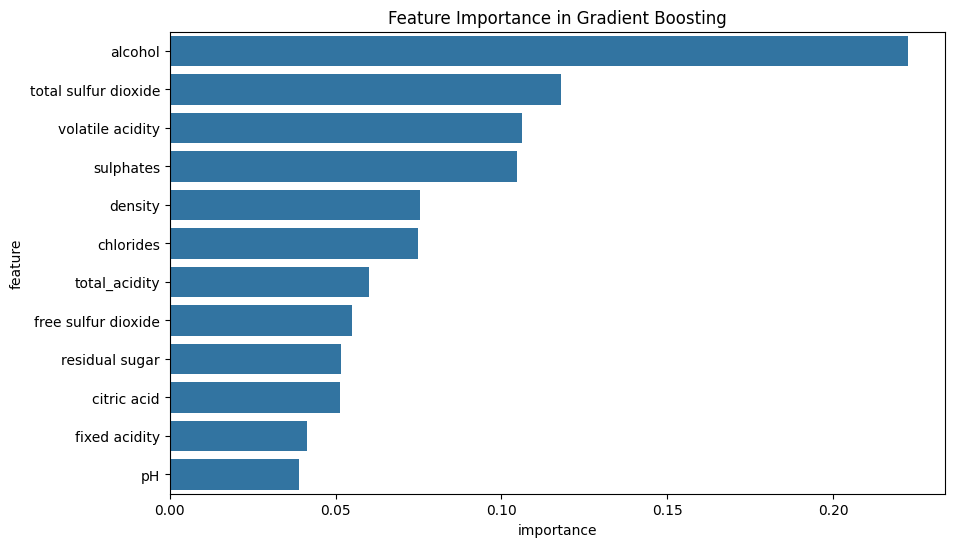

In [6]:
# visualize feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': gbm_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Gradient Boosting')
plt.show()

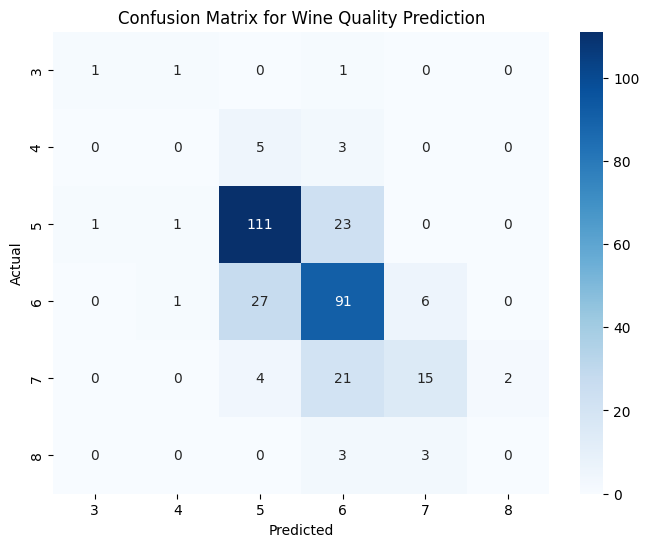

In [7]:
# visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(data['quality'].unique()), yticklabels=sorted(data['quality'].unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Wine Quality Prediction')
plt.show()

In [8]:
# save the trained model2 to a file using joblib for later use
model_dir = project_dir + '/model' 
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'wine_quality_gbm_model.pkl')
joblib.dump(gbm_model, model_filename)
print(f'Model saved as {model_filename}')

Model saved as ./05_gradient_boosting/model/wine_quality_gbm_model.pkl


In [9]:
# load the model and run a prediction test 
loaded_model = joblib.load(model_filename)

sample_data = pd.DataFrame(
    [[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 8.1]],
    columns=features
)
sample_input_scaled = scaler.transform(sample_data)  
sample_prediction = loaded_model.predict(sample_input_scaled)
print(f'Predicted Wine Quality for sample input: {sample_prediction[0]}')

Predicted Wine Quality for sample input: 5


/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
